In [1]:
from fast_rl.core.basic_train import AgentLearner
from fast_rl.agents.dqn import DQN, BaseDQNCallback
from fast_rl.core.train import AgentInterpretation, GroupAgentInterpretation
from fast_rl.core.data_block import MDPDataBunch
from fast_rl.core.agent_core import ExperienceReplay, GreedyEpsilon, PriorityExperienceReplay
import torch
from fastai.gen_doc.nbdoc import *
from fastai.basic_data import DatasetType

## Databunch for Training / Validation
For reinforcement learning, training might take a long time.

Note that if you want to avoid validation running, just turn it off and reflect the change in 
the interpretation objects. The agent will train much faster, and then you could validate later.
```python
data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', 
                             add_valid=False, bs=128)
AgentInterpretation(learn=learn, ds_type=DatasetType.Train)
```

In [9]:
data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32)

In [13]:
show_doc(DQN.__init__)

<h4 id="DQN.__init__" class="doc_header"><code>__init__</code><a class="source_link" data-toggle="collapse" data-target="#DQN-__init__-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>__init__</code>(**`data`**:`MDPDataBunch`, **`memory`**=***`None`***, **`lr`**=***`0.00025`***, **`discount`**=***`0.95`***, **`grad_clip`**=***`5`***, **`max_episodes`**=***`None`***, **`exploration_strategy`**=***`None`***, **`use_embeddings`**=***`False`***, **`layers`**=***`None`***, **`loss_func`**=***`None`***, **`optimizer`**=***`None`***)

<div class="collapse" id="DQN-__init__-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#DQN-__init__-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>__init__</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Trains an Agent using the Q Learning method on a neural net. Notes:
    This is not a true implementation of [1]. A true implementation uses a fixed target network.

References:
    [1] Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning."
    arXiv preprint arXiv:1312.5602 (2013).

Args:
    data: Used for size input / output information. 

In [12]:
show_doc(BaseDQNCallback.__init__)
show_doc(BaseDQNCallback.on_loss_begin)

<h4 id="BaseDQNCallback.__init__" class="doc_header"><code>__init__</code><a class="source_link" data-toggle="collapse" data-target="#BaseDQNCallback-__init__-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>__init__</code>(**`learn`**, **`max_episodes`**=***`None`***)

<div class="collapse" id="BaseDQNCallback-__init__-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#BaseDQNCallback-__init__-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>__init__</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Handles basic DQN end of step model optimization.  

<h4 id="BaseDQNCallback.on_loss_begin" class="doc_header"><code>on_loss_begin</code><a class="source_link" data-toggle="collapse" data-target="#BaseDQNCallback-on_loss_begin-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>on_loss_begin</code>(**\*\*`kwargs`**:`Any`)

<div class="collapse" id="BaseDQNCallback-on_loss_begin-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#BaseDQNCallback-on_loss_begin-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>on_loss_begin</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Performs memory updates, exploration updates, and model optimization.  

The batch size will be defined in the data class because `DataBunches` already require a 
batch size input. This batch size will be used by the model during optimization.

## Experience Replay

In [14]:
model = DQN(data, memory=ExperienceReplay(memory_size=100000, reduce_ram=True),
           lr=0.00025, optimizer=torch.optim.RMSprop)

Used by fastai API for training the model.

epoch,train_loss,valid_loss,time
0,1.080170,1.018711,00:05
1,1.025953,0.999318,00:03
2,1.017009,0.997538,00:01
3,1.002530,0.983602,00:05
4,0.999197,0.979198,00:01
5,0.992371,0.975168,00:02
6,0.984023,0.978879,00:01
7,0.980700,0.976000,00:01
8,0.972511,0.961403,00:03
9,0.971492,0.966446,00:02


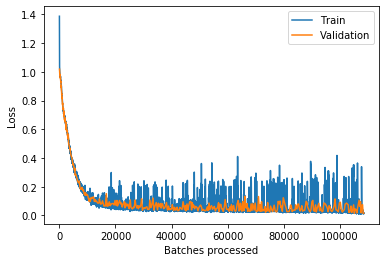

In [15]:
learn = AgentLearner(data, model)
learn.fit(450)
data.close()
learn.recorder.plot_losses()

In [16]:
interp = AgentInterpretation(learn)

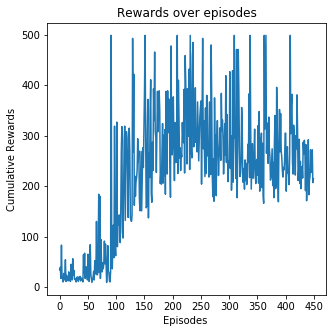

In [17]:
interp.plot_rewards(cumulative=True, per_episode=True, group_name='er_rms')

We can also pipe-line this to truly see how our model actually performs.

In [ ]:
group_interp = GroupAgentInterpretation()
group_interp.add_interpretation(interp)
for i in range(5):
    data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32, add_valid=False)
    model = DQN(data, memory=ExperienceReplay(memory_size=100000, reduce_ram=True),
                lr=0.00025, optimizer=torch.optim.RMSprop)
    learn = AgentLearner(data, model)
    learn.fit(450)
    interp = AgentInterpretation(learn, ds_type=DatasetType.Train)
    interp.plot_rewards(cumulative=True, per_episode=True, group_name='er_rms', no_show=True)
    group_interp.add_interpretation(interp)
    group_interp.to_pickle('data/dqn', 'dqn_er_rms')
    data.close()

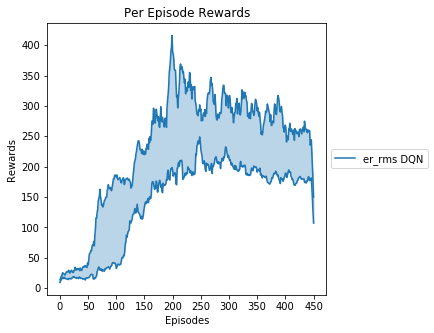

In [2]:
group_interp = GroupAgentInterpretation.from_pickle('data/dqn', 'dqn_er_rms')
group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)

In [15]:
[g.analysis for g in group_interp.groups]

[{'average': 199.03392461197336, 'max': 347.0, 'min': 10.0, 'type': 'reward'},
 {'average': 184.72993348115298, 'max': 293.1, 'min': 13.8, 'type': 'reward'},
 {'average': 147.2281596452328, 'max': 255.2, 'min': 9.5, 'type': 'reward'},
 {'average': 179.03348115299337, 'max': 276.1, 'min': 12.7, 'type': 'reward'},
 {'average': 206.25476718403547, 'max': 416.1, 'min': 11.6, 'type': 'reward'}]

## Priority Experience Replay

In [ ]:
per_group_interp = GroupAgentInterpretation()
per_group_interp.add_interpretation(interp)
for i in range(4):
    data = MDPDataBunch.from_env('CartPole-v1', render='rgb_array', bs=32)
    model = DQN(data, memory=PriorityExperienceReplay(memory_size=100000, reduce_ram=True))
    learn = AgentLearner(data, model)
    learn.fit(450)
    interp = AgentInterpretation(learn, ds_type=DatasetType.Train)
    interp.plot_rewards(cumulative=True, per_episode=True, group_name='per_rms', no_show=True)
    per_group_interp.add_interpretation(interp)
    group_interp.to_pickle('data/dqn', 'dqn_per')
    data.close()

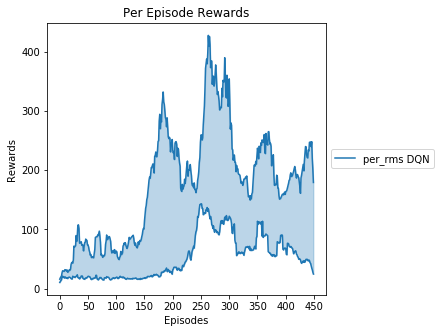

In [3]:
per_group_interp = GroupAgentInterpretation.from_pickle('data/dqn', 'dqn_per_rms')
per_group_interp.plot_reward_bounds(per_episode=True, smooth_groups=10)